#Image classification based on the Normalized Compression Distance

David RAKOTO - Quentin TARDIF

### Load dataset

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import zlib
import cv2
import gzip
from io import BytesIO
import lzma
import time
import random
from IPython.display import clear_output

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist

# Split the dataset into training and testing sets
(x_train_init, y_train_init), (x_test_init, y_test_init) = mnist.load_data()

clear_output()

# Print the shape of the training and testing data
print("x_train.shape:\t", x_train_init.shape)
print("y_train.shape:\t", y_train_init.shape)
print("x_test.shape:\t", x_test_init.shape)
print("y_test.shape:\t", y_test_init.shape)

x_train.shape:	 (60000, 28, 28)
y_train.shape:	 (60000,)
x_test.shape:	 (10000, 28, 28)
y_test.shape:	 (10000,)


### Useful functions

In [ ]:
# Display functions
def display_image(image):
    """
    Displays a MNIST image given its pixel values.

    Parameters:
    image (numpy.ndarray): A 2D numpy array representing the pixel values of a single MNIST image.

    Returns:
    None
    """
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def display_images(images):
    """
    Displays a grid of MNIST images given their pixel values.

    Parameters:
    images (numpy.ndarray): A 3D numpy array representing the pixel values of multiple MNIST images.

    Returns:
    None
    """
    images = images[:25]

    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5,5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Transformations
def rotate(images, degrees):
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

    datagen = ImageDataGenerator(
        rotation_range=degrees          # Rotate the image by up to 10 degrees
        )

    datagen.fit(images)
    return datagen.flow(images, batch_size=images.shape[0])[0]


def zoom(images, rate):
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

    datagen = ImageDataGenerator(
        zoom_range=rate,             # Zoom in or out by up to 10%
        )

    datagen.fit(images)
    return datagen.flow(images, batch_size=images.shape[0])[0]


def translate(images, rate):
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

    datagen = ImageDataGenerator(
        width_shift_range=0.1,      # Shift the image horizontally by up to 10%
        height_shift_range=0.1      # Shift the image vertically by up to 10%
        )

    datagen.fit(images)
    return datagen.flow(images, batch_size=images.shape[0])[0]


def flip(images):
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], 1)

    datagen = ImageDataGenerator(
        horizontal_flip=True,       # Flip the image horizontally with probability 0.5
        vertical_flip=True,         # Flip the image vertically with probability 0.5
        )

    datagen.fit(images)
    return datagen.flow(images, batch_size=images.shape[0])[0]

def add_gaussian_noise(images, mean=0, std=10):
    noisy_images = []
    
    for image in images:
        # Add Gaussian noise to the image
        noise = np.random.normal(mean, std, size=image.shape)
        noisy_image = cv2.add(image, noise, dtype=cv2.CV_8UC3)
        noisy_images.append(noisy_image)
    
    return np.array(noisy_images)

In [ ]:
# Apply transformations
def transform(x_train, rotate_degrees = 90, zoom_rate = 0.5, translate_rate = 0.9, gaussian_mean = 0, gaussian_std = 10, transformations=[0,0,0,0,0]):
    x_train_augmented = []

    if transformations[0]:
      x_train_augmented.append(rotate(x_train, rotate_degrees))
    if transformations[1]:
      x_train_augmented.append(zoom(x_train, zoom_rate))
    if transformations[2]:
      x_train_augmented.append(translate(x_train, translate_rate))
    if transformations[3]:
      x_train_augmented.append(flip(x_train))
    if transformations[4]:
      x_train_augmented.append(add_gaussian_noise(x_train, mean=gaussian_mean, std=gaussian_std).reshape(100,28,28,1))
    
    return np.array(list(itertools.chain(*x_train_augmented)))

In [ ]:
def size_compr_im(img, comp):
  
  buffer = BytesIO()
  img.convert('RGB').save(buffer, comp)

  return(buffer.getbuffer().nbytes)

comp_map = {'gzip': gzip, 'lzma': lzma, 'zlib': zlib, 'jpeg': 'JPEG', 'gif': 'GIF', 'png': 'PNG'}

In [ ]:
def concat_im(im1, im2, axis=0):
    """
    Concatening images horizontally (axis=0) or vertically (axis=1)
    """

    if axis==0:
      dst = Image.new('RGB', (im1.width + im2.width, im1.height))
      dst.paste(im1, (0, 0))
      dst.paste(im2, (im1.width, 0))

    else:
      dst = Image.new('RGB', (im1.width, im1.height + im2.height))
      dst.paste(im1, (0, 0))
      dst.paste(im2, (0, im1.height))
    return dst


def ncd(arr_im1, arr_im2, comp):

  im1 = Image.fromarray(arr_im1)
  im2 = Image.fromarray(arr_im2)

  im12 = concat_im(im1, im2)

  compressor = comp_map[comp]

  if comp in ['lzma', 'gzip', 'zlib']:
    c1 = len(compressor.compress(im1.tobytes()))
    c2 = len(compressor.compress(im2.tobytes()))
    c12 = len(compressor.compress(im12.tobytes()))
  
  else:
    c1 = size_compr_im(im1, compressor)
    c2 = size_compr_im(im2, compressor)
    c12 = size_compr_im(im12, compressor)

  ncd = (c12 - min(c1, c2))/max(c1, c2)

  return ncd

def concat_inter(arr_im1, arr_im2, axis=0):
  """
    Concatening images line by line (axis=0) or column by column (axis=1)
  """

  if axis == 0:
    c = arr_im1[0]
    
    for i in range(arr_im1.shape[0]):
      c = np.vstack((c, arr_im1[i]))
      c = np.vstack((c, arr_im2[i]))
    
    im = Image.fromarray(c[1:])
  
  else:
    c = np.column_stack((arr_im1, arr_im2)).reshape(-1,2,28).transpose(0,2,1).reshape(28,-1)
    im = Image.fromarray(c)

  return(im)



def ncd2(arr_im1, arr_im2, comp):

  arr_im1 = arr_im1.reshape(28, 28)
  arr_im2 = arr_im2.reshape(28, 28)

  im1 = Image.fromarray(arr_im1)
  im2 = Image.fromarray(arr_im2)

  im12 = concat_inter(arr_im1, arr_im2, axis=1)

  compressor = comp_map[comp]

  if comp in ['lzma', 'gzip', 'zlib']:
    c1 = len(compressor.compress(im1.tobytes()))
    c2 = len(compressor.compress(im2.tobytes()))
    c12 = len(compressor.compress(im12.tobytes()))
  
  else:
    c1 = size_compr_im(im1, compressor)
    c2 = size_compr_im(im2, compressor)
    c12 = size_compr_im(im12, compressor)

  ncd = (c12 - min(c1, c2))/max(c1, c2)

  return ncd

In [ ]:
# Intra-class dispersion
def WSS(X, distance, compressor, n_samples=None):
  # Sort samples
  X_clusters = [X[y_train_init==i] for i in range(10)]

  # Compute centroids
  X_centroids = [np.mean(X_clusters[i], axis=0) for i in range(10)]

  # Compute WSS
  WSS = sum([sum([distance(x, X_centroids[i], comp=compressor)**2 for x in X_clusters[i][:n_samples]]) for i in range(10)])

  return WSS

# Inter-class dispersion
def BSS(X, distance, compressor, n_samples=None):
  # Sort samples
  X_clusters = [X[y_train_init==i] for i in range(10)]

  # Compute centroids
  X_centroids = [np.mean(X_clusters[i], axis=0) for i in range(10)]

  # Compute absolute centroid
  abs_centroid = np.mean(X_centroids, axis=0)

  # Compute BSS
  BSS = sum([len(X_clusters[i])*distance(X_centroids[i], abs_centroid, comp=compressor)**2 for i in range(10)])

  return BSS

# Array of intra-class distances
def array_average_intra_class_distances(X, distance, compressor, n_samples=None):
  # Sort samples
  X_clusters = [X[y_train_init==i] for i in range(10)]

  # Compute centroids
  X_centroids = [np.mean(X_clusters[i], axis=0) for i in range(10)]

  # Compute WSS
  WSS = [np.mean([distance(x, X_centroids[i], comp=compressor)**2 for x in X_clusters[i][:n_samples]], axis=0) for i in range(10)]

  return WSS

# Matrix of inter-cluster distances
def matrix_inter_cluster_distances(X, distance, compressor):
  M_distances = np.zeros((10, 10))
  
  # Sort samples
  X_clusters = [X[y_train_init==i] for i in range(10)]

  # Compute centroids
  X_centroids = [np.mean(X_clusters[i], axis=0) for i in range(10)]

  # Compute distances between centroids
  for i in range(10):
    for j in range(i+1, 10):
      M_distances[i][j] = distance(X_centroids[i], X_centroids[j], comp=compressor)**2
      M_distances[j][i] = M_distances[i][j]
  
  return M_distances

In [ ]:
def display_heatmap(M, compressor_name, lbl):
  # Display the matrix as a heatmap
  plt.figure(figsize=(12,6))
  if lbl: plt.title("Line-by-line NCD inter-cluster distance with "+compressor_name)
  else: plt.title("Side-by-side NCD inter-cluster distance with "+compressor_name)
  
  plt.imshow(M, cmap='hot', interpolation='nearest', vmin=0, vmax=2.5)
  #plt.imshow(M, cmap='hot', interpolation='nearest')
  plt.colorbar()

  plt.savefig(f'/content/drive/MyDrive/Algorithmic Information/figures/NCD2_intreclass_{compressor_name}.png')

  plt.show()
  print()

### Compare basic NCD with different compression algorithms

In [ ]:
n_samples = 10000

In [ ]:
# Plot intra-distances
  
# set height of bar
x1_1 = array_average_intra_class_distances(x_train_init, distance=ncd, compressor='png', n_samples=n_samples)
x2_1 = array_average_intra_class_distances(x_train_init, distance=ncd, compressor='jpeg', n_samples=n_samples)
x3_1 = array_average_intra_class_distances(x_train_init, distance=ncd, compressor='gif', n_samples=n_samples)

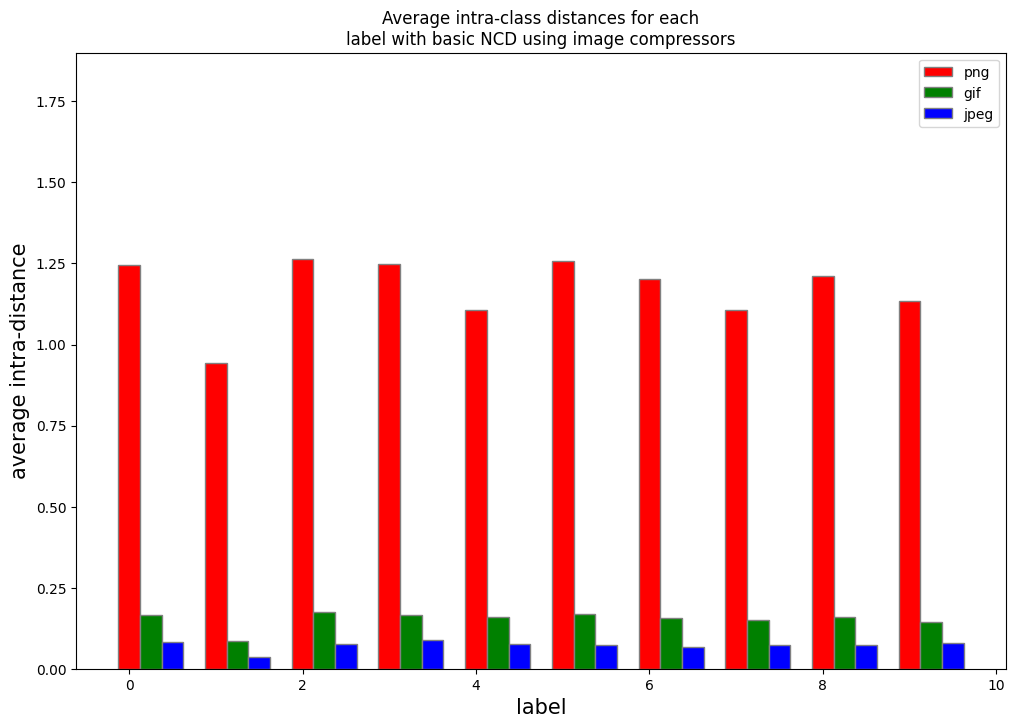

In [ ]:
# Set position of bar on X axis
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(x1_1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
  
# Make the plot
plt.title("Average intra-class distances for each\nlabel with basic NCD using image compressors")
plt.bar(br1, x1_1, color ='r', width = barWidth,
        edgecolor ='grey', label ='png')
plt.bar(br2, x3_1, color ='g', width = barWidth,
        edgecolor ='grey', label ='gif')
plt.bar(br3, x2_1, color ='b', width = barWidth,
        edgecolor ='grey', label ='jpeg')
  
plt.xlabel('label', fontsize = 15)
plt.ylim([0, 1.9])
plt.ylabel('average intra-distance', fontsize = 15)
plt.legend()

plt.savefig('/content/drive/MyDrive/Algorithmic Information/figures/NCD_intraclass_png-jpeg-gif.png')

plt.show()

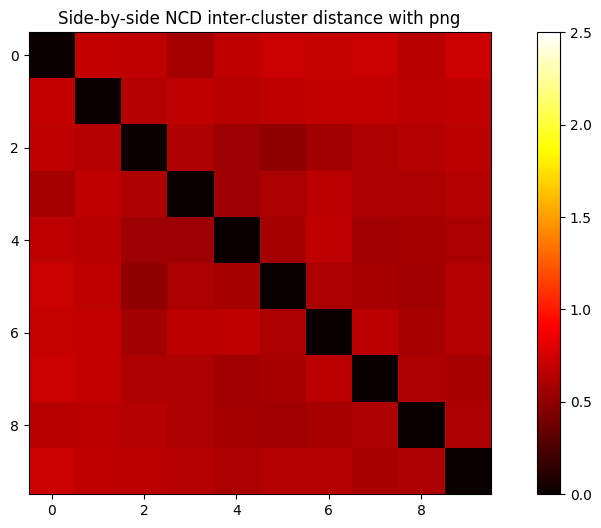

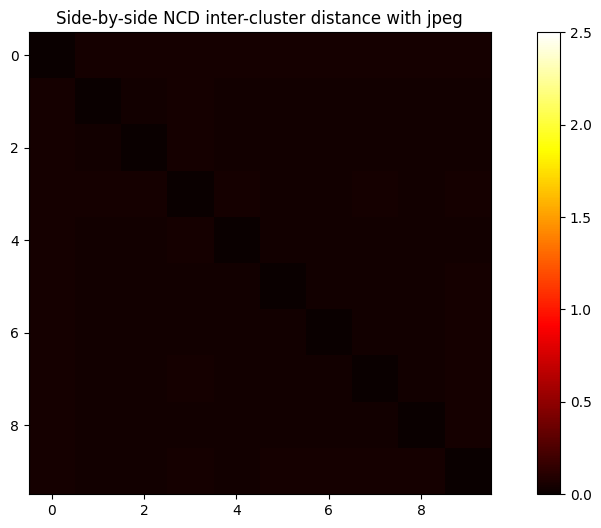

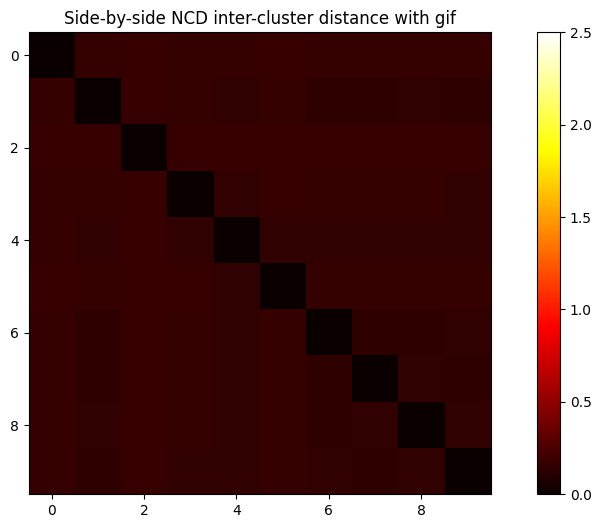

In [ ]:
M1_1 = matrix_inter_cluster_distances(x_train_init, distance=ncd, compressor='png')
display_heatmap(M1_1, 'png', lbl=False)

M2_1 = matrix_inter_cluster_distances(x_train_init, distance=ncd, compressor='jpeg')
display_heatmap(M2_1, 'jpeg', lbl=False)

M3_1 = matrix_inter_cluster_distances(x_train_init, distance=ncd, compressor='gif')
display_heatmap(M3_1, 'gif', lbl=False)

In [ ]:
wss_zlib_1 = sum(x1_1)
print("png:\t", wss_zlib_1)

wss_gzip_1 = sum(x2_1)
print("jpeg:\t", wss_gzip_1)

wss_lzma_1 = sum(x3_1)
print("gif:\t", wss_lzma_1)

png:	 11.716239731203688
jpeg:	 0.7281936167211496
gif:	 1.5278474425812378


In [ ]:
bss_zlib_1 = BSS(x_train_init, distance=ncd, compressor='png', n_samples=None)
print("png:\t", bss_zlib_1)

bss_gzip_1 = BSS(x_train_init, distance=ncd, compressor='jpeg', n_samples=None)
print("jpeg:\t", bss_gzip_1)

bss_lzma_1 = BSS(x_train_init, distance=ncd, compressor='gif', n_samples=None)
print("gif:\t", bss_lzma_1)

png:	 37652.73828637674
jpeg:	 2069.3853539116044
gif:	 10540.37119162604


---BASIC NCD---
Calinski-Harabasz index
- png:  3213.7220772375254
- jpeg:  2841.806500899394
- gif:  6898.837474125361



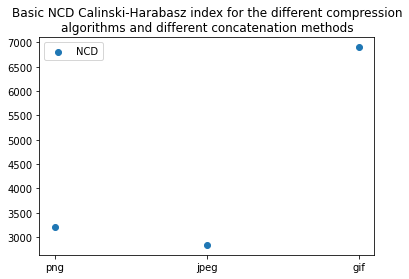

In [ ]:
print("---BASIC NCD---")
print("Calinski-Harabasz index")
print("- png: ", bss_zlib_1/wss_zlib_1)
print("- jpeg: ", bss_gzip_1/wss_gzip_1)
print("- gif: ", bss_lzma_1/wss_lzma_1)
print()
plt.title('Basic NCD Calinski-Harabasz index for the different compression\nalgorithms and different concatenation methods')
plt.scatter(['png', 'jpeg', 'gif'],[bss_zlib_1/wss_zlib_1, bss_gzip_1/wss_gzip_1, bss_lzma_1/wss_lzma_1], label='NCD')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Algorithmic Information/figures/NCD_CH_png-jpeg-gif.png')
plt.show()

### Compare new NCD with different compression algorithms

In [ ]:
n_samples = 10000

In [ ]:
# Plot intra-distances  
# set height of bar
x1_2 = array_average_intra_class_distances(x_train_init, distance=ncd2, compressor='png', n_samples=n_samples)
x2_2 = array_average_intra_class_distances(x_train_init, distance=ncd2, compressor='jpeg', n_samples=n_samples)
x3_2 = array_average_intra_class_distances(x_train_init, distance=ncd2, compressor='gif', n_samples=n_samples)

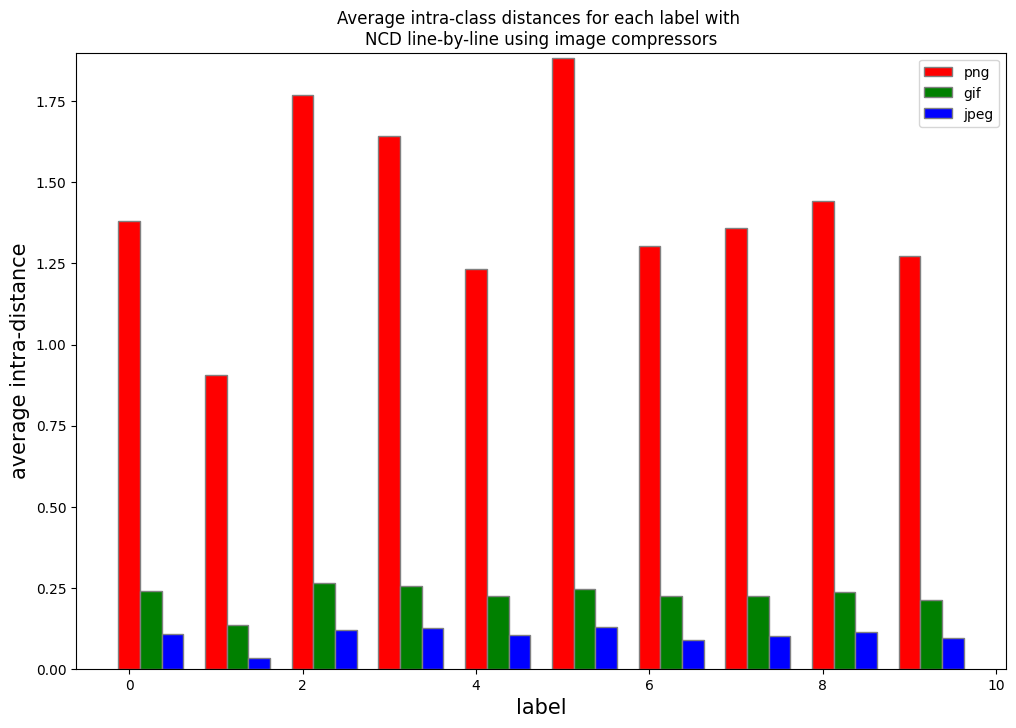

In [ ]:
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(x1_2))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
  
# Make the plot
plt.title("Average intra-class distances for each label with \nNCD line-by-line using image compressors")
plt.bar(br1, x1_2, color ='r', width = barWidth,
        edgecolor ='grey', label ='png')
plt.bar(br2, x3_2, color ='g', width = barWidth,
        edgecolor ='grey', label ='gif')
plt.bar(br3, x2_2, color ='b', width = barWidth,
        edgecolor ='grey', label ='jpeg') 
  
plt.xlabel('label', fontsize = 15)
plt.ylabel('average intra-distance', fontsize = 15)
plt.ylim([0, 1.9])
plt.legend()
plt.savefig('/content/drive/MyDrive/Algorithmic Information/figures/NCD2_intraclass_png-jpeg-gif.png')
plt.show()

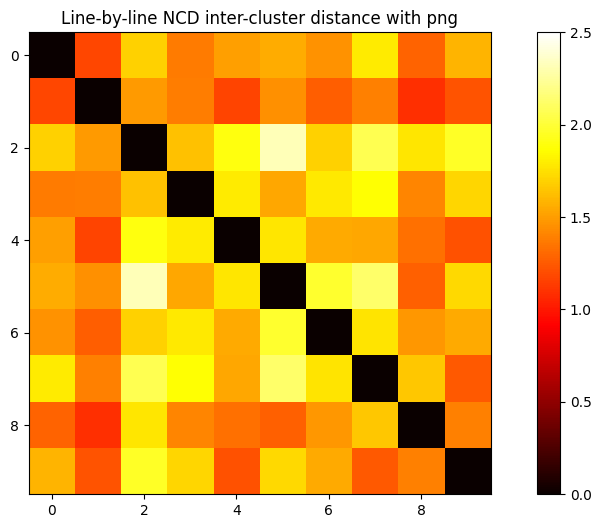

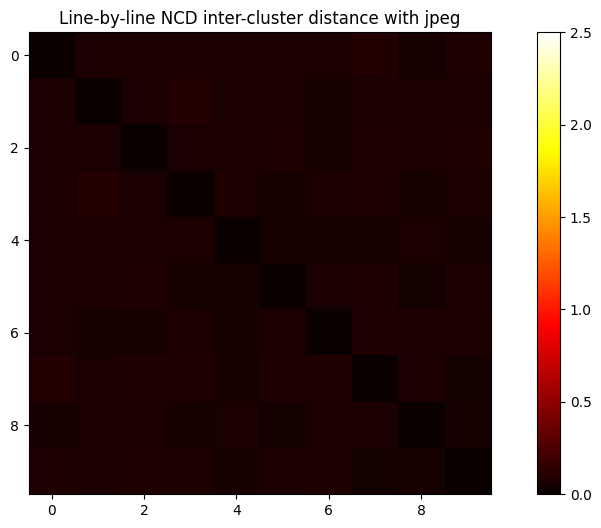

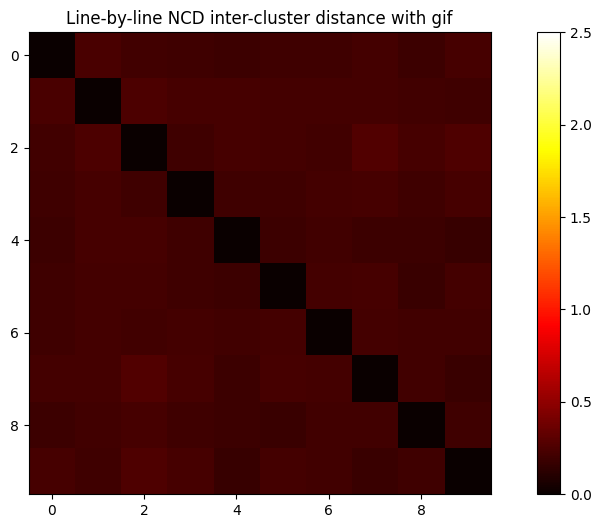

In [ ]:
M1_2 = matrix_inter_cluster_distances(x_train_init, distance=ncd2, compressor='png')
display_heatmap(M1_2, 'png', lbl=True)

M2_2 = matrix_inter_cluster_distances(x_train_init, distance=ncd2, compressor='jpeg')
display_heatmap(M2_2, 'jpeg', lbl=True)

M3_2 = matrix_inter_cluster_distances(x_train_init, distance=ncd2, compressor='gif')
display_heatmap(M3_2, 'gif', lbl=True)

In [ ]:
wss_zlib_2 = sum(x1_2)
print("png: ", wss_zlib_2)

wss_gzip_2 = sum(x2_2)
print("jpeg: ", wss_gzip_2)

wss_lzma_2 = sum(x3_2)
print("gif: ", wss_lzma_2)

png:  14.198059905005053
jpeg:  1.018882290355243
gif:  2.259224650345287


In [ ]:
bss_zlib_2 = BSS(x_train_init, distance=ncd2, compressor='png', n_samples=None)
print("png: ", bss_zlib_2)

bss_gzip_2 = BSS(x_train_init, distance=ncd2, compressor='jpeg', n_samples=None)
print("jpeg: ", bss_gzip_2)

bss_lzma_2 = BSS(x_train_init, distance=ncd2, compressor='gif', n_samples=None)
print("gif: ", bss_lzma_2)

png:  89477.35605767698
jpeg:  3319.53211046071
gif:  12978.234033585528


---IMPROVED NCD---
Calinski-Harabasz index
- png:  6302.08328858612
- jpeg:  3258.013356286057
- gif:  5744.552243444231



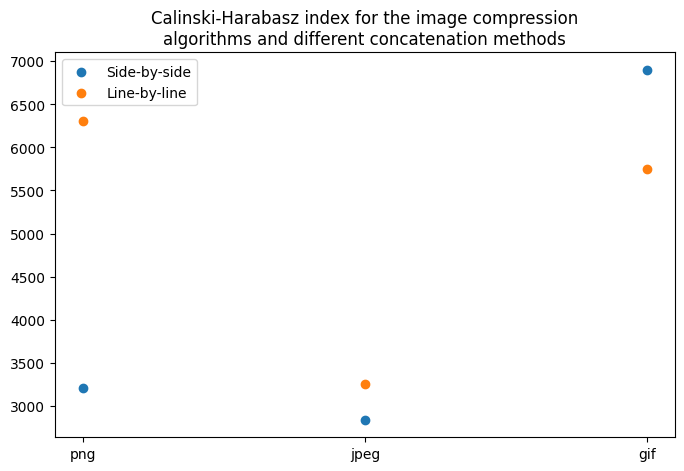

In [ ]:
print("---IMPROVED NCD---")
print("Calinski-Harabasz index")
print("- png: ", bss_zlib_2/wss_zlib_2)
print("- jpeg: ", bss_gzip_2/wss_gzip_2)
print("- gif: ", bss_lzma_2/wss_lzma_2)
print()
plt.figure(figsize=(8,5))
plt.title('Calinski-Harabasz index for the image compression\nalgorithms and different concatenation methods')
plt.scatter(['png', 'jpeg', 'gif'],[bss_zlib_1/wss_zlib_1, bss_gzip_1/wss_gzip_1, bss_lzma_1/wss_lzma_1], label='Side-by-side')
plt.scatter(['png', 'jpeg', 'gif'],[bss_zlib_2/wss_zlib_2, bss_gzip_2/wss_gzip_2, bss_lzma_2/wss_lzma_2], label='Line-by-line')
plt.legend()
plt.savefig('/content/drive/MyDrive/Algorithmic Information/figures/NCD1-2_CH_png-jpeg-gif.png')

### Robustness to transformations (unused)

##### Translation

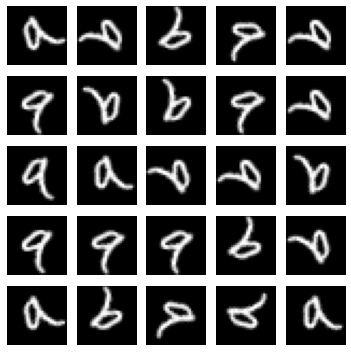

In [ ]:
nb_images = 100
images_init = [x_train_init[y_train_init==i][0] for i in range(10)]
x_train = rotate(np.array([images_init[9]]*nb_images), degrees=360)
display_images(x_train)

In [ ]:
def WSS1(X, compressor):
  # Compute centroid
  X_centroid = np.mean(X, axis=0)

  # Compute WSS
  WSS1 = sum([ncd(x, X_centroid, compressor=compressor)**2 for x in X])

  return WSS1

In [ ]:
nb_images = 100
list_wss1_zlib = []
list_wss1_gzip = []
list_wss1_lzma = []

images_init = [x_train_init[y_train_init==i][0] for i in range(10)]

for i in range(10):
  print("label: ", i)
  list_label_zlib = []
  list_label_gzip = []
  list_label_lzma = []
  for j, param in enumerate(np.linspace(0, 1, num=10)):
    print(f"{j+1}/{10}")
    x_train = translate(np.array([images_init[i]]*nb_images), rate=param)
    list_label_zlib.append(WSS1(x_train, zlib))
    list_label_gzip.append(WSS1(x_train, gzip))
    list_label_lzma.append(WSS1(x_train, lzma))
  clear_output()

  list_wss1_zlib.append(list_label_zlib)
  list_wss1_gzip.append(list_label_gzip)
  list_wss1_lzma.append(list_label_lzma)

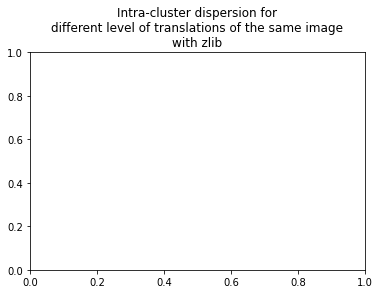

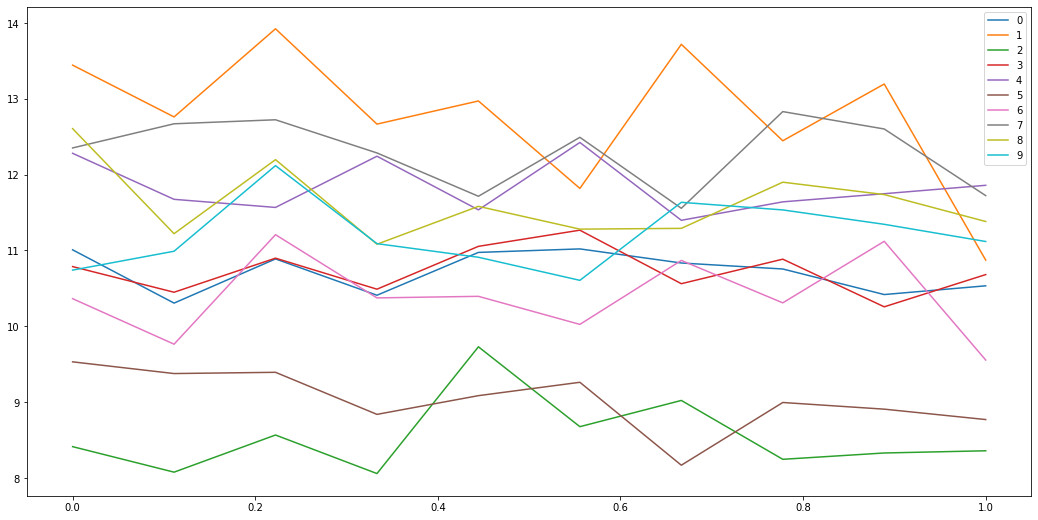

In [ ]:
plt.title("Intra-cluster dispersion for\ndifferent level of translations of the same image\nwith zlib")
plt.figure(figsize=(18,9))
for i in range(10):
  plt.plot(np.linspace(0, 1, num=10), list_wss1_zlib[i], label=str(i))
plt.legend()
plt.show()
plt.clf()

plt.title("Intra-cluster dispersion for\ndifferent level of translations of the same image\nwith gzip")
plt.figure(figsize=(18,9))
for i in range(10):
  plt.plot(np.linspace(0, 1, num=10), list_wss1_gzip[i], label=str(i))
plt.legend()
plt.show()
plt.clf()

plt.title("Intra-cluster dispersion for\ndifferent level of translations of the same image\nwith lzma")
plt.figure(figsize=(18,9))
for i in range(10):
  plt.plot(np.linspace(0, 1, num=10), list_wss1_lzma[i], label=str(i))
plt.legend()
plt.show()
plt.clf()

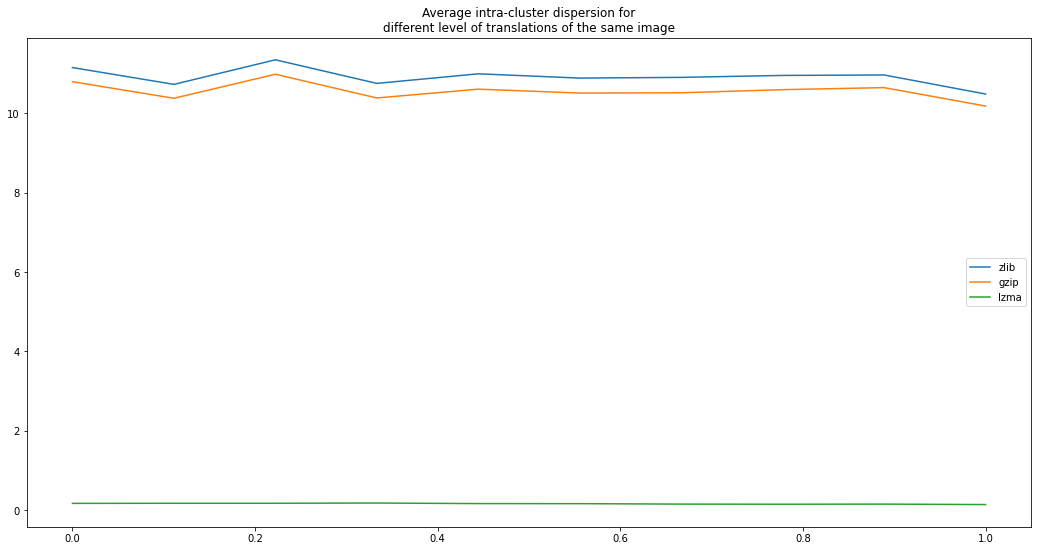

In [ ]:
plt.figure(figsize=(18,9))
plt.title("Average intra-cluster dispersion for\ndifferent level of translations of the same image")
plt.plot(np.linspace(0, 1, num=10), np.mean(list_wss1_zlib, axis=0), label='zlib')
plt.plot(np.linspace(0, 1, num=10), np.mean(list_wss1_gzip, axis=0), label='gzip')
plt.plot(np.linspace(0, 1, num=10), np.mean(list_wss1_lzma, axis=0), label='lzma')
plt.legend()
plt.show()

##### Rotation

In [ ]:
nb_images = 100
list_wss1_zlib = []
list_wss1_gzip = []
list_wss1_lzma = []

images_init = [x_train_init[y_train_init==i][0] for i in range(10)]

for i in range(10):
  print("label: ", i)
  list_label_zlib = []
  list_label_gzip = []
  list_label_lzma = []
  for j, param in enumerate(np.linspace(0, 360, num=10)):
    print(f"{j+1}/{10}")
    x_train = rotate(np.array([images_init[i]]*nb_images), degrees=param)
    list_label_zlib.append(WSS1(x_train, zlib))
    list_label_gzip.append(WSS1(x_train, gzip))
    list_label_lzma.append(WSS1(x_train, lzma))
  clear_output()

  list_wss1_zlib.append(list_label_zlib)
  list_wss1_gzip.append(list_label_gzip)
  list_wss1_lzma.append(list_label_lzma)

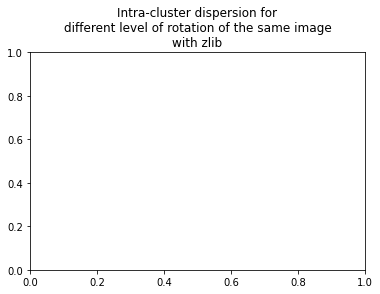

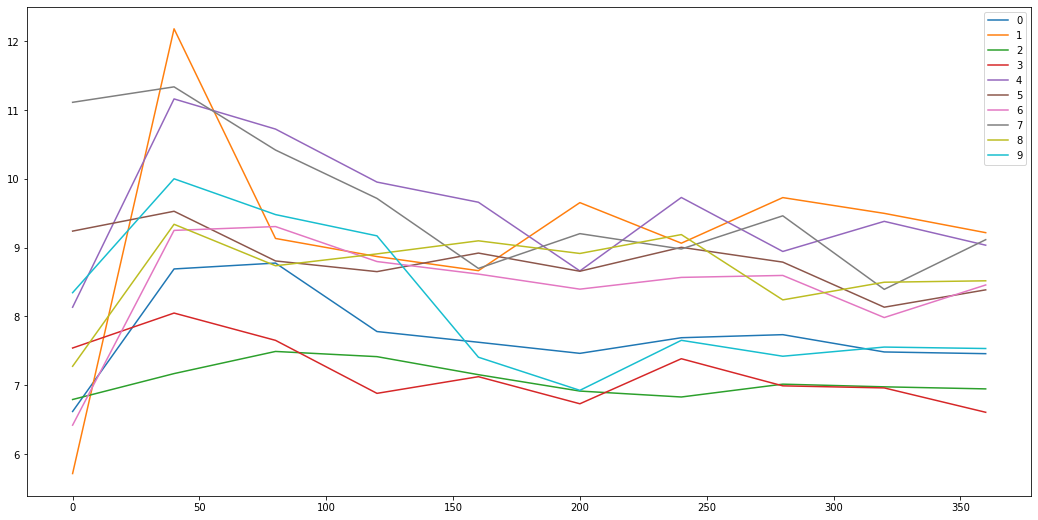

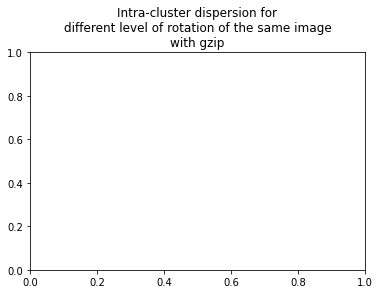

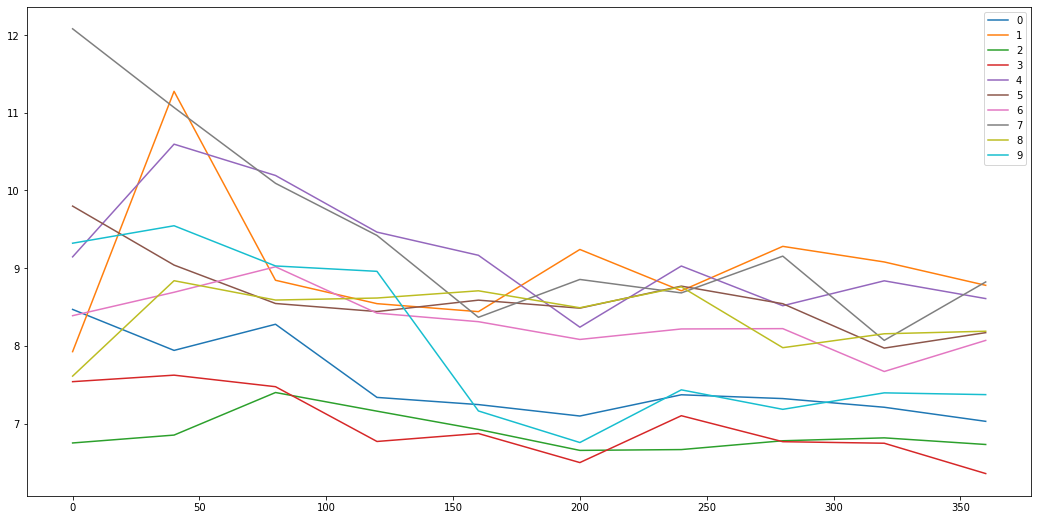

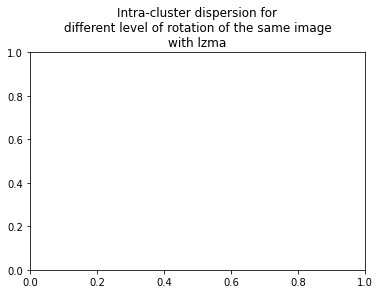

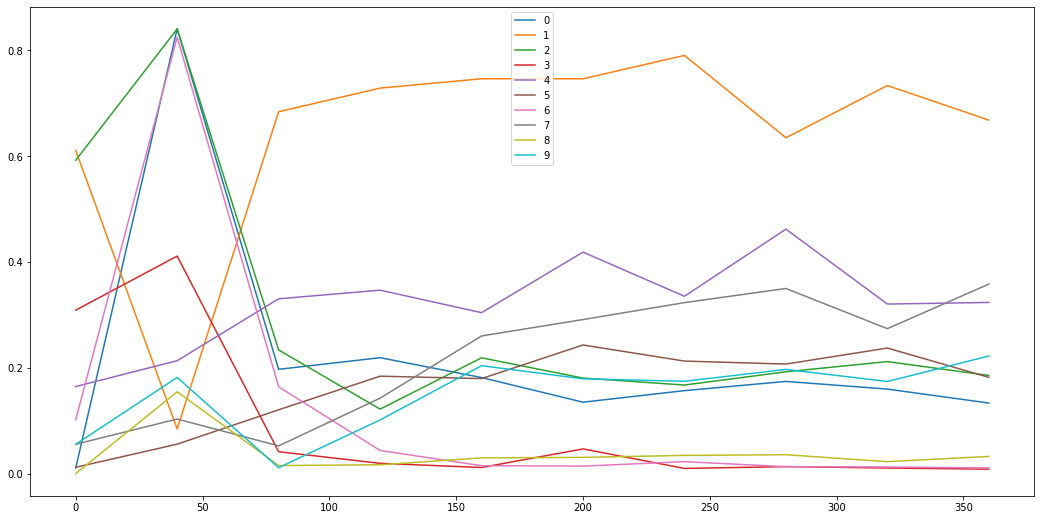

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.title("Intra-cluster dispersion for\ndifferent level of rotation of the same image\nwith zlib")
plt.figure(figsize=(18,9))
for i in range(10):
  plt.plot(np.linspace(0, 360, num=10), list_wss1_zlib[i], label=str(i))
plt.legend()
plt.show()
plt.clf()

plt.title("Intra-cluster dispersion for\ndifferent level of rotation of the same image\nwith gzip")
plt.figure(figsize=(18,9))
for i in range(10):
  plt.plot(np.linspace(0, 360, num=10), list_wss1_gzip[i], label=str(i))
plt.legend()
plt.show()
plt.clf()

plt.title("Intra-cluster dispersion for\ndifferent level of rotation of the same image\nwith lzma")
plt.figure(figsize=(18,9))
for i in range(10):
  plt.plot(np.linspace(0, 360, num=10), list_wss1_lzma[i], label=str(i))
plt.legend()
plt.show()
plt.clf()

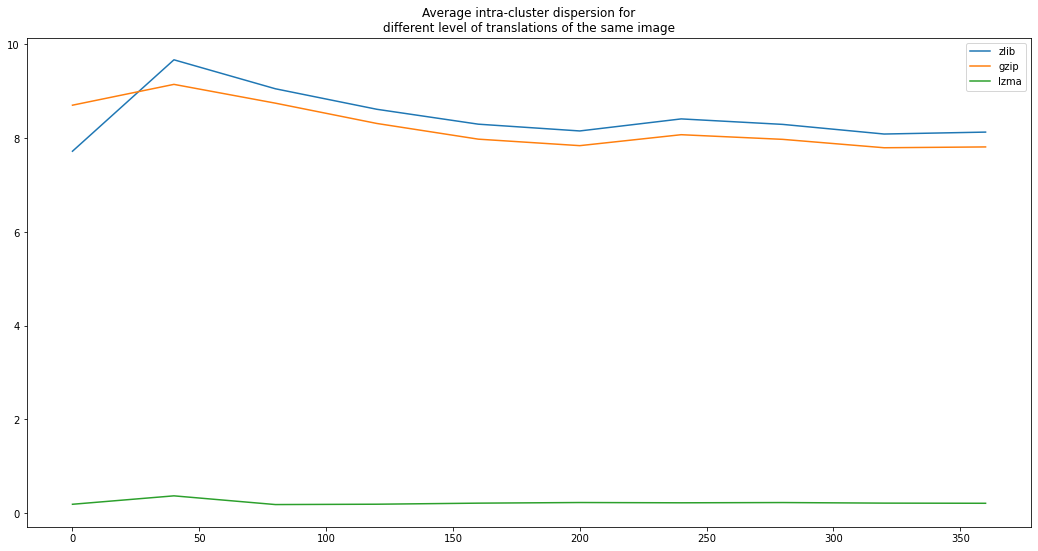

In [ ]:
plt.figure(figsize=(18,9))
plt.title("Average intra-cluster dispersion for\ndifferent level of translations of the same image")
plt.plot(np.linspace(0, 360, num=10), np.mean(list_wss1_zlib, axis=0), label='zlib')
plt.plot(np.linspace(0, 360, num=10), np.mean(list_wss1_gzip, axis=0), label='gzip')
plt.plot(np.linspace(0, 360, num=10), np.mean(list_wss1_lzma, axis=0), label='lzma')
plt.legend()
plt.show()

##### Gaussian noise

In [ ]:
nb_images = 100
list_wss1_zlib = []
list_wss1_gzip = []
list_wss1_lzma = []

images_init = [x_train_init[y_train_init==i][0] for i in range(10)]

for i in range(10):
  print("label: ", i)
  list_label_zlib = []
  list_label_gzip = []
  list_label_lzma = []
  for j, param in enumerate(np.linspace(0, 360, num=10)):
    print(f"{j+1}/{10}")
    x_train = add_gaussian_noise(np.array([images_init[i]]*nb_images), degrees=param)
    list_label_zlib.append(WSS1(x_train, zlib))
    list_label_gzip.append(WSS1(x_train, gzip))
    list_label_lzma.append(WSS1(x_train, lzma))
  clear_output()

  list_wss1_zlib.append(list_label_zlib)
  list_wss1_gzip.append(list_label_gzip)
  list_wss1_lzma.append(list_label_lzma)

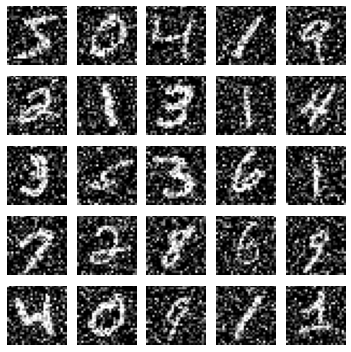

In [ ]:
display_images(add_gaussian_noise(x_train_init[:25], std=100))